            Date          Open          High           Low         Close  \
0      2014.9.17  4.826118e+05  4.838110e+05  4.681210e+05  4.732035e+05   
1      2014.9.18  4.727130e+05  4.762765e+05  4.309914e+05  4.428182e+05   
2      2014.9.19  4.424667e+05  4.475154e+05  4.012784e+05  4.119893e+05   
3      2014.9.20  4.118610e+05  4.417305e+05  4.068624e+05  4.267118e+05   
4      2014.9.21  4.258571e+05  4.303872e+05  4.103040e+05  4.161897e+05   
...          ...           ...           ...           ...           ...   
3327  2023.10.27  4.668672e+07  4.730157e+07  4.585433e+07  4.615730e+07   
3328  2023.10.28  4.615710e+07  4.641771e+07  4.534866e+07  4.598915e+07   
3329  2023.10.29  4.598633e+07  4.665314e+07  4.594169e+07  4.623296e+07   
3330  2023.10.30  4.623269e+07  4.711951e+07  4.604037e+07  4.684124e+07   
3331  2023.10.31  4.683210e+07  4.699302e+07  4.603332e+07  4.645787e+07   

            Volume  
0     2.178747e+10  
1     3.597632e+10  
2     3.957110e+10  
3  

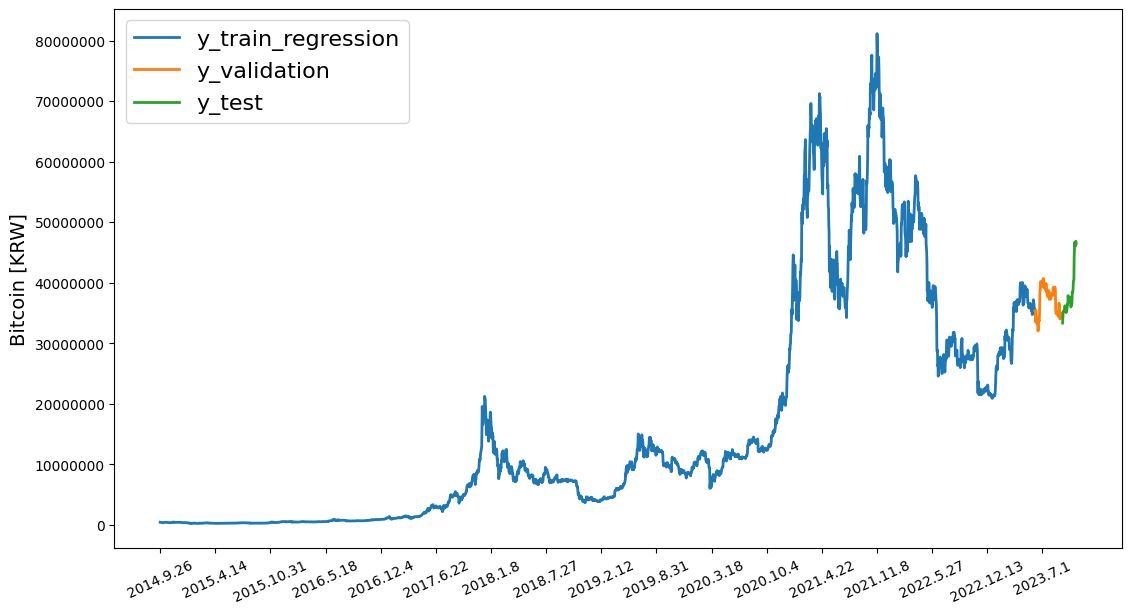

In [5]:
# https://finance.yahoo.com/quote/BTC-KRW/history/
import pandas as pd
from pathlib import Path
import os
import torch
import matplotlib.pyplot as plt

# 주피터 노트북에서는 __file__ 변수가 정의되지 않기에 직접 설정할 것임
# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl


# 본 과제 제출자는 현재 우분투 도커 환경에서 작업중이므로 다음과 같이 경로 설정
BASE_PATH="/home/Deep-Learning-study"
import sys
sys.path.append(BASE_PATH)


# 비트코인 가격 csv파일 경로 설정
btc_krw_path = os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW.csv")
df = pd.read_csv(btc_krw_path)
print(df)


# 데이터 행 크기 출력
row_size = len(df)
print("row_size:", row_size)

# 열 확인
columns = df.columns  #['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
print([column for column in columns])

# 날짜 열 제거
date_list = df['Date']
df = df.drop(columns=['Date'])

print(df)
print("#" * 100, 0)

#################################################################################################

# 시퀀스, 데이터셋 크기 설정
sequence_size = 10
validation_size = 100
test_size = 50

# 학습 데이터 크기 설정
data_size = row_size - sequence_size + 1
print("data_size: {0}".format(data_size))
train_size = data_size - (validation_size + test_size)
print("train_size: {0}, validation_size: {1}, test_size: {2}".format(train_size, validation_size, test_size))

print("#" * 100, 1)

#################################################################################################

row_cursor = 0
y_normalizer = 1.0e7

# 학습 데이터
X_train_list = []
# regression을 위한 리스트
y_train_regression_list = []
# classification을 위한 리스트
y_train_classification_list = []
# 날짜 저장 리스트
y_train_date = []

# 학습 데이터 생성 루프
for idx in range(0, train_size):
  # 시퀀스 데이터 생성
  sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
  X_train_list.append(torch.from_numpy(sequence_data))
  # regression 레이블 추가
  y_train_regression_list.append(df.iloc[idx + sequence_size - 1]["Close"])
  y_train_classification_list.append(
    1 if df.iloc[idx + sequence_size - 1]["Close"] >= df.iloc[idx + sequence_size - 2]["Close"] else 0
  )
  y_train_date.append(date_list[idx + sequence_size - 1])
  row_cursor += 1


# 학습 데이터 텐서로 변환
X_train = torch.stack(X_train_list, dim=0).to(torch.float)
y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)
print(y_train_classification)


# 데이터 정규화
m = X_train.mean(dim=0, keepdim=True)
s = X_train.std(dim=0, keepdim=True)
X_train -= m
X_train /= s
print(X_train.shape, y_train_regression.shape, y_train_classification.shape)
print("Label - Start Date: {0} ~ End Date: {1}".format(y_train_date[0], y_train_date[-1]))

print("#" * 100, 2)

#################################################################################################


# validation 데이터 생성
# train 데이터 생성 과정과 동일
X_validation_list = []
y_validation_regression_list = []
y_validation_classification_list = []
y_validation_date = []
for idx in range(row_cursor, row_cursor + validation_size):
  sequence_data = df.iloc[idx: idx + sequence_size].values     # sequence_data.shape: (sequence_size, 5)
  X_validation_list.append(torch.from_numpy(sequence_data))
  y_validation_regression_list.append(df.iloc[idx + sequence_size - 1]["Close"])
  y_validation_classification_list.append(
    1 if df.iloc[idx + sequence_size - 1]["Close"] >= df.iloc[idx + sequence_size - 2]["Close"] else 0
  )
  y_validation_date.append(date_list[idx + sequence_size - 1])
  row_cursor += 1

X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)
print(y_validation_classification)

X_validation = (X_validation - m) / s
print(X_validation.shape, y_validation_regression.shape, y_validation_classification.shape)
print("Label - Start Date: {0} ~ End Date: {1}".format(y_validation_date[0], y_validation_date[-1]))

print("#" * 100, 3)

#################################################################################################


# test 데이터 생성
# 이전에 데이터 처리 과정과 동일
X_test_list = []
y_test_regression_list = []
y_test_classification_list = []
y_test_date = []
for idx in range(row_cursor, row_cursor + test_size):
  sequence_data = df.iloc[idx: idx + sequence_size].values   # sequence_data.shape: (sequence_size, 5)
  X_test_list.append(torch.from_numpy(sequence_data))
  y_test_regression_list.append(df.iloc[idx + sequence_size - 1]["Close"])
  y_test_classification_list.append(
    1 if df.iloc[idx + sequence_size - 1]["Close"] > df.iloc[idx + sequence_size - 2]["Close"] else 0
  )
  y_test_date.append(date_list[idx + sequence_size - 1])
  row_cursor += 1

X_test = torch.stack(X_test_list, dim=0).to(torch.float)
y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)
print(y_test_classification)
X_test = (X_test - m) / s
print(X_test.shape, y_test_regression.shape, y_test_classification.shape)
print("Label - Start Date: {0} ~ End Date: {1}".format(y_test_date[0], y_test_date[-1]))

#######################################################################################


# pandas 활용하여 시각화
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train_date, y_train_regression * y_normalizer, label="y_train_regression", linewidth=2)
ax.plot(y_validation_date, y_validation_regression * y_normalizer, label="y_validation", linewidth=2)
ax.plot(y_test_date, y_test_regression * y_normalizer, label="y_test", linewidth=2)
ax.set_ylabel('Bitcoin [KRW]', fontsize=14)
ax.set_xticks(ax.get_xticks()[::200])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=25)
ax.legend(loc='upper left', fontsize=16)
plt.show()

